# Capstone

## Problem statement

Using News Article sentiment to determine next day market change.

### Executive Summary
GDELT is an open platform project that monitors the world's broadcast, print, and web news.  It performs sentiment analysis on thousands of articles in 15 minute increments.  I created a function to download gdelt's data up to 24 hours before the market opens. I then turned that data into a time series of hours and found the trendline for each of my features to find the directionality of change throughout the day leading up to the markets opening.  I then took that data for every day the market was open starting February 20, 2015 and ending November 22, 2016.  I calculated a 7 day volatility and added it to the 8th day in the series of dates and added in a one day market value change shifted one day.  I then applied Linear Regression, Logistic Regression, XGBoost, Nearest Neighbor, Decision Trees, Random Forests, and Extra Trees to my data.  I most extensively tested Logistic Regression and XGBoost.  At first XGBoost was giving very promising results, however Logistic Regression gave better results with a lower standard deviation.  I plan to continue testing with XGBoost as I learn how to better tune its parameters.  The mean Logistic Regression model accuracy is 2-3% better than random.

### Features:

<br><b>Tone:</b> Average “tone” of the document as a whole. This is calculated as
Positive Score minus Negative Score. A document with a Tone score close to zero may
either have low emotional response or may have a Positive Score and Negative Score
that are roughly equivalent to each other, such that they nullify each other.
<br><b>Positive Score:</b> Percentage of all words in the article
that were found to have a positive emotional connotation. Ranges from 0 to +100.
<br><b>Negative Score:</b> Percentage of all words in the
article that were found to have a negative emotional connotation. Ranges from 0 to
+100.
<br><b>Polarity:</b> Percentage of words that had matches in
the tonal dictionary as an indicator of how emotionally polarized or charged the text is.
<br><b>Activity:</b> Percentage of words
that were active words offering a very basic proxy of the overall “activeness” of the text.
<br><b>Word Count:</b> Total number of words in the document.
<br><b>Volatility:</b> Market volatility of the previous 7 open market days.
<br><b>Shifted Value</b> Previous day's Open Price minus Close Price.

# Description of Data Pipeline

- Download S&P500 data.
- Download Data from GDelt.
- Clean the data.
- Model the data.

### Stock Data Source

*Plan to replace this in the future with a self updating pull using pandas_datareader.data<br>*

- Dow Jones Data Source
https://fred.stlouisfed.org/series/DJIA/downloaddata

- SP500 Data Source
https://fred.stlouisfed.org/series/SP500/downloaddata

### Data Download Function

```python
def download_data(day_of, day_before):
    day_before_begin = 144500    #  2:45 pm (GMT)
    day_before_end   = 234500    # 11:45 pm (GMT)
    day_of_begin     = 0         # 12:00 am (GMT)
    day_of_end       = 143000    #  2:30 pm (GMT)
    while (day_before_begin <= day_before_end):
        x1 = day_before + str(day_before_begin) + '.gkg.csv.zip'
        x2 = 'http://data.gdeltproject.org/gdeltv2/' + x1
        day_before_begin+=1500
        if str(60) in str(day_before_begin):
            day_before_begin+=4000
        x3 = 'capzips/' + x1
        urllib.urlretrieve(x2, x3)
        
    while (day_of_begin <= day_of_end):
        x1 = day_of + '{:06d}'.format(day_of_begin) + '.gkg.csv.zip'
        x2 = 'http://data.gdeltproject.org/gdeltv2/' + x1
        day_of_begin+=1500
        if str(60) in str(day_of_begin):
            day_of_begin+=4000
        x3 = 'capzips/' + x1
        urllib.urlretrieve(x2, x3)
    extract_zip()
```

### Opens data and extracts relevant features.

```python
# Opens every csv and puts the data into a dataframe
def csv_to_df_no_GCAM():
    csv_df = pd.DataFrame()
    for name in glob.glob('capzips/*.csv'):
        try:
            logger.debug('File name: %s', name)
            temp_df = pd.read_csv(name, header=None, sep="\t", usecols=[1,15])
            temp_df['Date'], temp_df['TONE'] = temp_df[1], temp_df[15]
            temp_df = temp_df[['Date', 'TONE']]
            
            # This section is necessary do not remove.
            if temp_df['Date'].dtypes != 'int64':
                temp_df.dropna(inplace=True)
                temp_df['Date'] = temp_df['Date'].astype(int)
        
            csv_df = pd.concat((csv_df,temp_df), ignore_index=True)
        except:
            logger.debug('File is empty: %s', name)
    return csv_df
```

### Data Cleaning

```python
# Splits the data into separate columns
def tone_parse(cvs):
    cvs['tone'] = [float(x.split(',')[0]) for x in cvs['TONE']]
    cvs['positive_score'] = [float(x.split(',')[1]) for x in cvs['TONE']]
    cvs['negative_score'] = [float(x.split(',')[2]) for x in cvs['TONE']]
    cvs['polarity'] = [float(x.split(',')[3]) for x in cvs['TONE']]
    cvs['activity'] = [float(x.split(',')[4]) for x in cvs['TONE']]
    cvs['word_count'] = [int(x.split(',')[6]) for x in cvs['TONE']]
    cvs.pop('TONE')
    return cvs
```

### Main Function
```python
def main_func(time_run):
    if time_run == 0:
        return "Not enough time to finish one loop."
    
    # We good fam.
    try:
        final_df = pd.read_pickle('last_df.pkl')
    except IOError:
        final_df = pd.DataFrame()
    
    
    # Prevents my program from running over and breaking.
    if len(final_df)+time_run >= len(df):
        upper_bound = len(df)-1
    else:
        upper_bound = len(final_df)+time_run
    
    # Main for loop that downloads, cleans, and stores relevant data.
    for p in range(len(final_df), upper_bound):
        # Downloads the data from the internet for the specified date.
        download_data(df['DATE'][p], df['Date'][p])
        
        
        # --------- TONE Section -------- #
        csv_df = tone_parse(csv_to_df_no_GCAM())
        csv_df['Date'] = [pd.to_datetime(datetime.strptime(str(x), '%Y%m%d%H%M%S')) for x in csv_df['Date']]
        csv_df = csv_df.set_index('Date')
        csv_df = csv_df.resample('h').mean()
        csv_df.dropna(inplace=True)
        csv_df.reset_index(inplace=True)
        temp = csv_df.columns[1:]
        test = pd.DataFrame([np.polyfit(csv_df.index, csv_df[x],1)[0] for x in csv_df.columns[1:].tolist()]).T
        test.columns = temp.tolist()
        # --------- TONE Section -------- #

        
        final_df = pd.concat([final_df, test], ignore_index=True)
        delete_csv()
        final_df['Date'] = df['DATE']
        pd.to_pickle(final_df, 'last_df.pkl')
        final_df = pd.read_pickle('last_df.pkl')
    play(seinfeld)
```
<b> Master Switch </b>
```python
main_func(run_time(20, 'm')) # m = minutes, h = hours      1 loop = ~5 minutes
```


# Exploratory Data Analysis

In [4]:
testDF = pd.read_pickle('last_df.pkl')
testDF.head()

,Date,activity,negative_score,polarity,positive_score,tone,word_count
0,20150220,-0.008517,-0.000372,-0.001839,-0.001467,-0.001096,1.310790
1,20150223,-0.005018,-0.002565,-0.010567,-0.008002,-0.005438,-0.658659
2,20150224,0.002874,-0.004673,-0.006598,-0.001925,0.002748,0.365012
3,20150225,-0.010078,-0.000191,0.001792,0.001983,0.002173,0.648857
4,20150226,-0.004835,-0.010998,-0.006280,0.004718,0.015715,0.844997


In [13]:
testDF.head()

,Date,activity,negative_score,polarity,positive_score,tone,word_count,value,shifted_value,Volatility,value_binary
0,20150303,-0.002042,-0.004188,-0.004990,-0.000803,0.003385,0.099662,-0.35,1.21,5.935257,0
1,20150304,-0.002408,-0.003338,-0.002785,0.000552,0.003890,0.921975,-0.17,-0.35,4.521195,0
2,20150305,-0.003321,-0.008528,-0.006243,0.002284,0.010812,0.444884,-0.16,-0.17,4.578665,0
3,20150306,0.004545,0.001455,0.001000,-0.000455,-0.001911,0.292905,-1.92,-0.16,4.177226,0
4,20150309,-0.012258,-0.012414,-0.008342,0.004072,0.016486,-0.678822,0.62,-1.92,6.621512,1


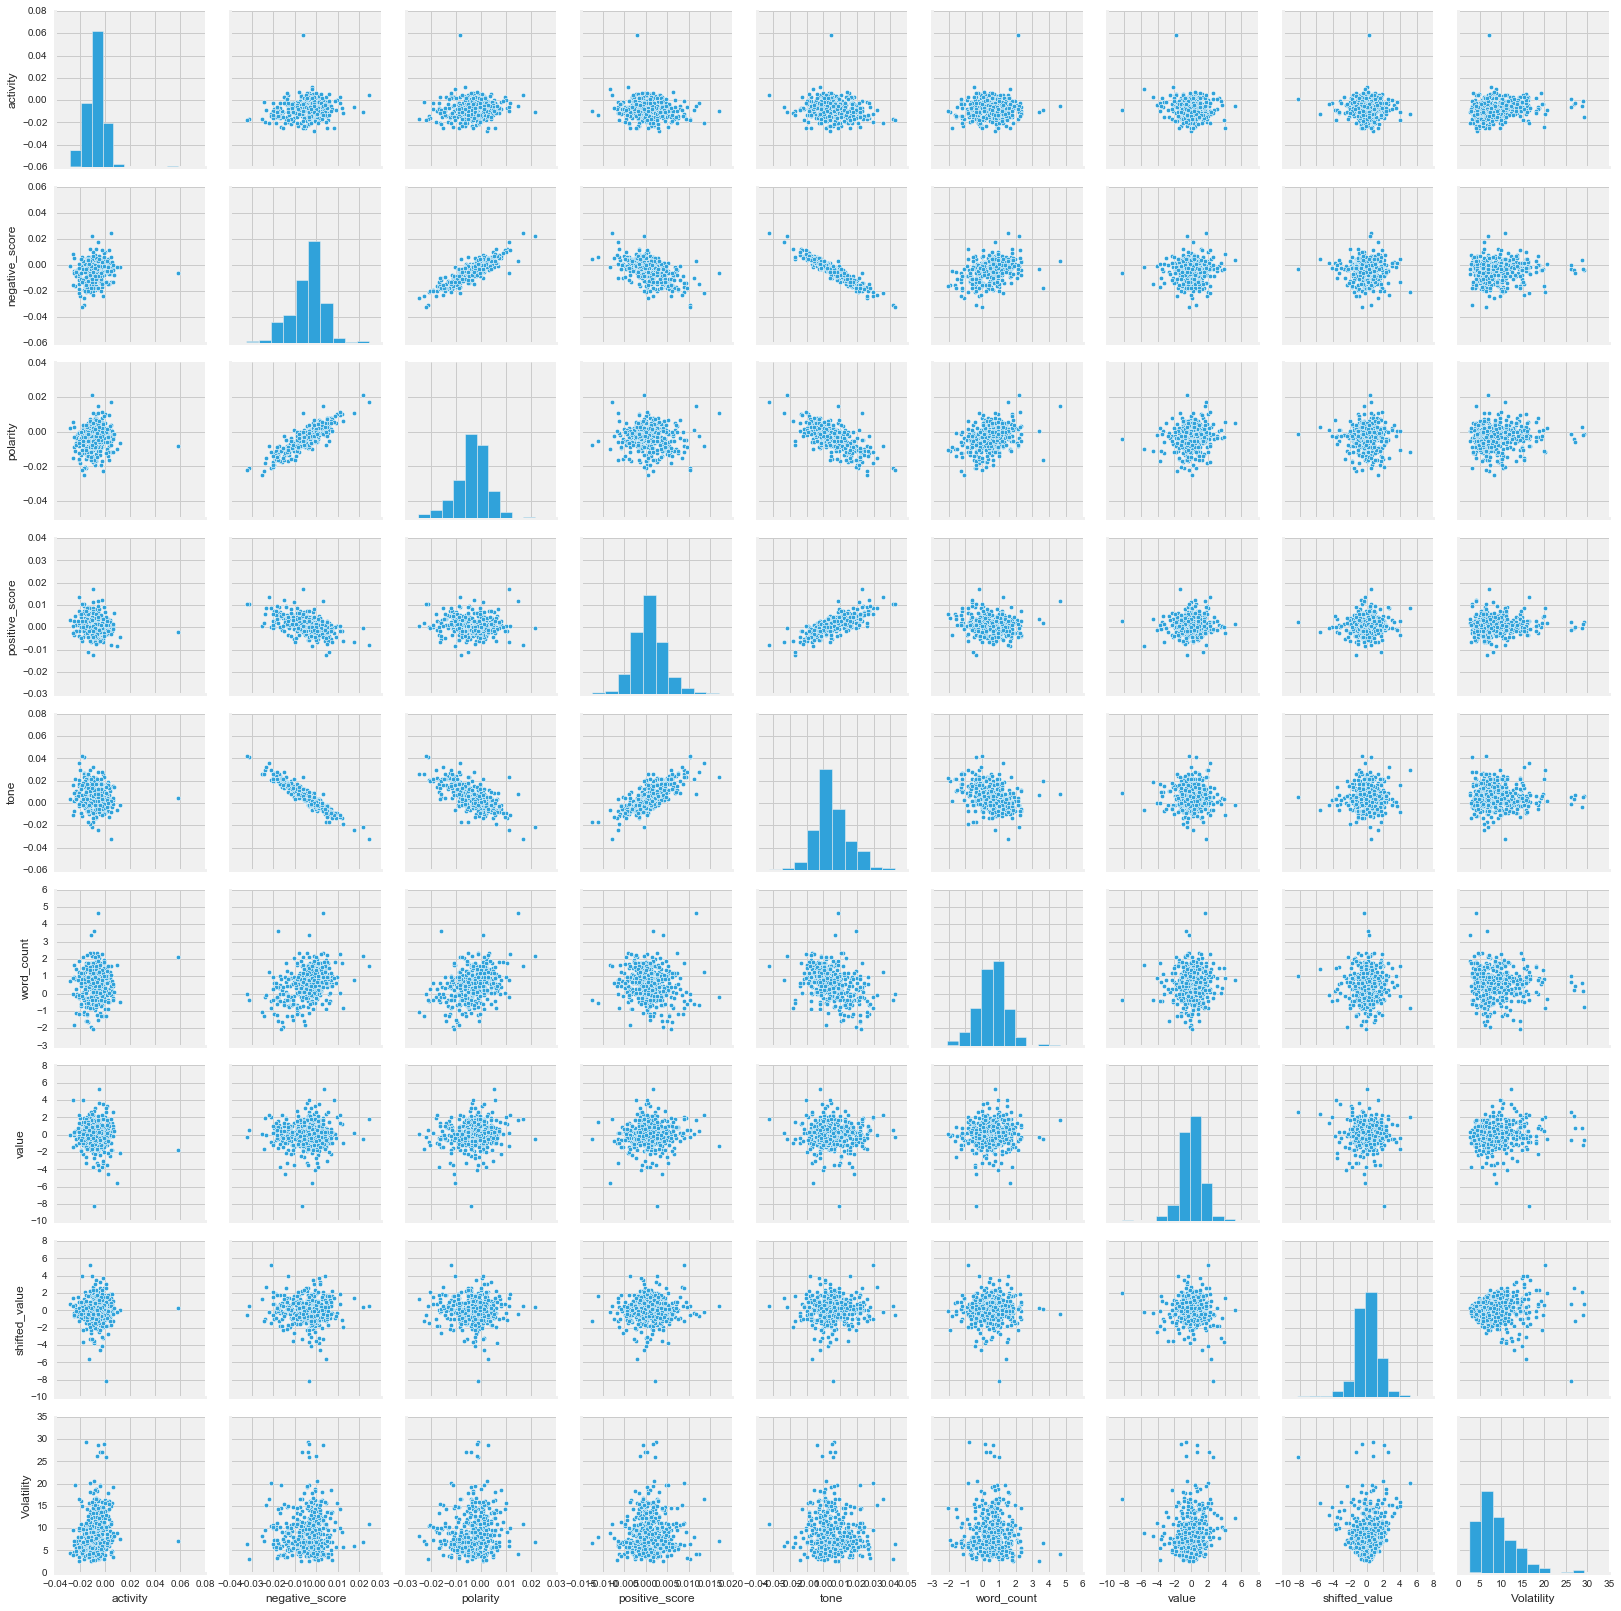

In [14]:
sns.pairplot(testDF[[1,2,3,4,5,6,7,8,9]])

MSE: 1.8024064598


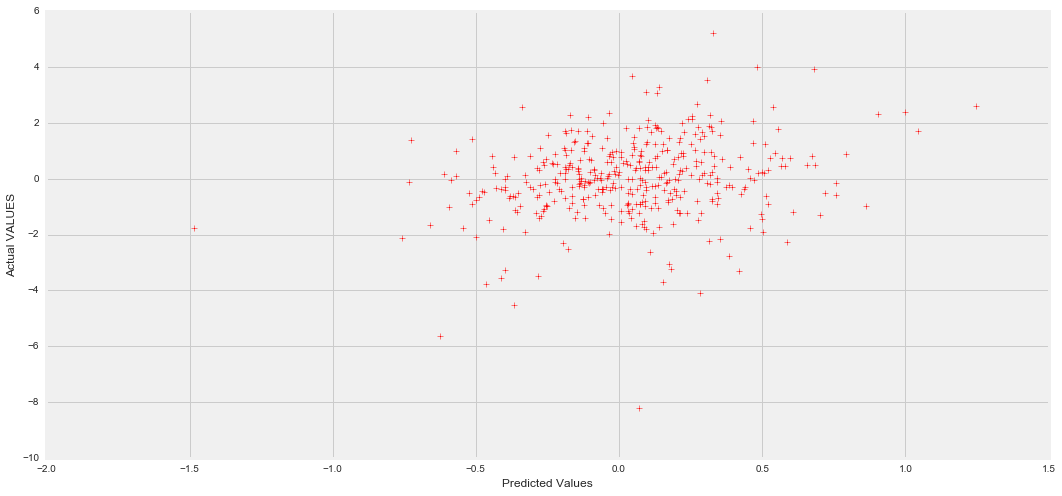

In [15]:
lm = linear_model.LinearRegression()

X = testDF[[1,2,3,4,5,6,8,9]]
y = testDF["value"]

lm.fit(X, y)
predictions = lm.predict(X)

print "MSE:", mean_squared_error(y, predictions)
plt.figure(figsize=(16,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual VALUES")
plt.show()

## XG Boost and Logistic Regression

Tested on data from November 23, 2016 to December 9, 2016.

In [32]:
#Single XG Boost model.

X_train = testDF[[1,2,3,4,5,6,8,9]]
Y_train = testDF['value_binary']

X_test = testdata[[1,2,3,4,5,6,8,9]]
Y_test = testdata['value_binary']


lr = xgboost.XGBClassifier()
#lr = LogisticRegressionCV(Cs=20, cv=10)
lr.fit(X_train, Y_train)

y_pred = lr.predict(X_test)

conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)

       predicted_over  predicted_under
over                6                3
under               1                2
             precision    recall  f1-score   support

          0       0.40      0.67      0.50         3
          1       0.86      0.67      0.75         9

avg / total       0.74      0.67      0.69        12



In [33]:
#Single Logistic Regression model.

X_train = testDF[[1,2,3,4,5,6,8,9]]
Y_train = testDF['value_binary']

X_test = testdata[[1,2,3,4,5,6,8,9]]
Y_test = testdata['value_binary']


#lr = xgboost.XGBClassifier()
lr = LogisticRegressionCV(Cs=20, cv=10)
lr.fit(X_train, Y_train)

y_pred = lr.predict(X_test)

conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)

       predicted_over  predicted_under
over                4                5
under               2                1
             precision    recall  f1-score   support

          0       0.17      0.33      0.22         3
          1       0.67      0.44      0.53         9

avg / total       0.54      0.42      0.46        12



In [24]:
coef = pd.DataFrame([X.columns.values.tolist(), lr.coef_[0].tolist()], index=['features', 'coef']).T
coef.sort_values(by='coef', ascending=False)

,features,coef
2,polarity,24.693
3,positive_score,19.2246
4,tone,13.7562
1,negative_score,5.46842
5,word_count,0.184974
7,Volatility,0.0262803
6,shifted_value,-0.09807
0,activity,-18.6698


#### Cross Val Mean of Cluster Models

In [26]:
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", cdt.mean().round(3), cdt.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", crf.mean().round(3), crf.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", cet.mean().round(3), cet.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Nearest Neighbor", ckc.mean().round(3), ckc.std().round(3)))
print 
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree Bagging", cbdt.mean().round(3), cbdt.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Bagging", cbrf.mean().round(3), cbrf.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees Bagging", cbet.mean().round(3), cbet.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Nearest Neighbor Bagging", cbkc.mean().round(3), cbkc.std().round(3)))

Decision Tree Score:	0.52 ± 0.23
Random Forest Score:	0.528 ± 0.248
Extra Trees Score:	0.501 ± 0.244
Nearest Neighbor Score:	0.522 ± 0.231

Decision Tree Bagging Score:	0.507 ± 0.224
Random Forest Bagging Score:	0.501 ± 0.223
Extra Trees Bagging Score:	0.488 ± 0.242
Nearest Neighbor Bagging Score:	0.531 ± 0.216


,dt_importance,rf_importance,et_importance
word_count,0.204191,0.135576,0.137285
activity,0.154137,0.122468,0.155670
Volatility,0.141439,0.147430,0.121828
tone,0.131913,0.098929,0.099260
positive_score,0.105321,0.109884,0.119514


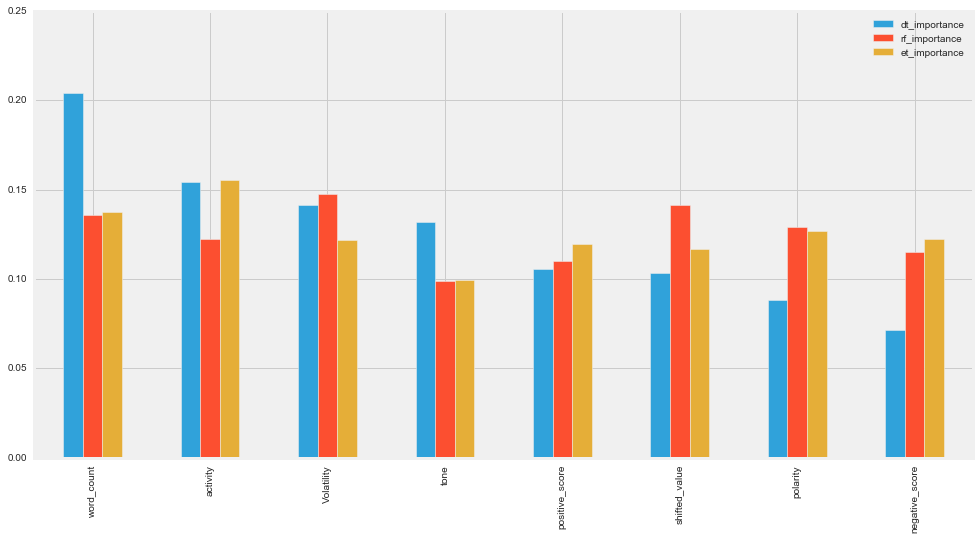

In [28]:
importances.plot(kind='bar', figsize=(15,8))
importances.head()

### GridsearchCV

I was unable to get GridSearch to provide better results than default params so I'm assuming I've screwed up somewhere but I don't know where.

In [29]:
# This method of optimization decreases precision and increases False Negatives and decreases True Positives

logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X_train, Y_train)

logreg = LogisticRegression(C=gs.best_params_['C'],penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, Y_train)
cv_pred = cv_model.predict(X_test)

conmat = np.array(confusion_matrix(Y_test, cv_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])
print(confusion)
print classification_report(Y_test, cv_pred)

       predicted_over  predicted_under
over                4                5
under               2                1
             precision    recall  f1-score   support

          0       0.17      0.33      0.22         3
          1       0.67      0.44      0.53         9

avg / total       0.54      0.42      0.46        12



Extra Trees Gridsearch gave promising results on recent data.

       predicted_over  predicted_under
over                7                2
under               1                2
             precision    recall  f1-score   support

          0       0.50      0.67      0.57         3
          1       0.88      0.78      0.82         9

avg / total       0.78      0.75      0.76        12

ROC Area Under Curve Score: 0.777777777778


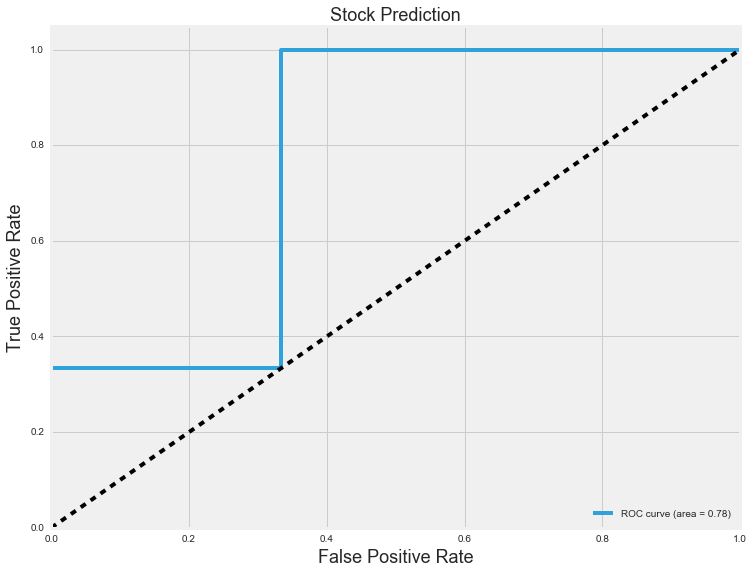

In [34]:
# GridSearch ExtraTrees. Unused.

gs2 = GridSearchCV(ExtraTreesClassifier(min_samples_leaf=10),
                  {'n_estimators': np.arange(10,50,10),
                  'max_features': np.arange(1,5,1)},
                  cv=10)
gs2.fit(X_train,Y_train)
y_pred2 = gs2.predict_proba(X_test)
tempDF = pd.DataFrame(y_pred2)
tempDF['actual'] = np.array(Y_test)

# Change to affect TP, FP, TN, FN
tempDF['threshold'] = tempDF[1].map(lambda x: 0 if x < 0.5 else 1)



conmat = np.array(confusion_matrix(Y_test, tempDF['threshold'], labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test, tempDF['threshold'])

print 'ROC Area Under Curve Score:', roc_auc_score(Y_test, tempDF[1])
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, tempDF[1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Stock Prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [31]:
# Test Model Performance by finding mean scores of 100 runs with random splits.

final_results = []
default_results = []
test_results = []
base_accuracy = []
better_count = 0

for count in range(100):
    X = testDF[[1,2,3,4,5,6,8,9]]
    y = testDF["value_binary"]

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    
    #lr = xgboost.XGBClassifier()
    lr = LogisticRegressionCV(Cs=20, cv=10)
    lr.fit(X_train,Y_train)

    y_pred = lr.predict(X_test)

    #--------This section needs to be re-evaluated and editted--------#  Done?
    Y_test_index = pd.DataFrame(Y_test).reset_index()
    Y_test_and_predict = pd.concat((Y_test_index, pd.DataFrame(y_pred)),axis=1)

    Y_test_and_predict = Y_test_and_predict.set_index('index')
    Y_test_and_predict['guess'] = Y_test_and_predict[0]
    Y_test_and_predict.pop(0)
    fest = pd.concat((Y_test_and_predict, testDF['value']), axis=1).dropna()
    fest.reset_index(drop=True, inplace=True)

    positive, negative = 0, 0
    for x in range(len(fest)):
        if fest['guess'][x] == 1:
            if fest['value_binary'][x] == fest['guess'][x]:
                positive += abs(fest['value'][x])
            else:
                negative += abs(fest['value'][x])
    #---------------------------------------------------------------#
    
    results = positive - negative
    final_results.append(results)
    
    conmat = confusion_matrix(Y_test, y_pred, labels=[1,0])
    test_results.append((conmat[0][0]+conmat[1][1])/float(len(Y_test)))
    
    base_accuracy.append((conmat[0][0]+conmat[0][1])/float(len(Y_test)))
    
    right_pos = [x for x in fest['value'] if x > 0]
    right_neg = [x for x in fest['value'] if x < 0]
    dresults = np.sum(right_pos) - abs(np.sum(right_neg))
    default_results.append(dresults)
    
    if results >= dresults:
        better_count+=1
print 'Mean of Model Accuracy:', np.mean(test_results)
print 'Mean of  Base Accuracy:', np.mean(base_accuracy)
print 'Model Standard Deviation:', np.std(test_results).round(3)
print 'Number of times model is better than buying every day. Out of 100:', better_count

Mean of Model Accuracy: 0.544251968504
Mean of  Base Accuracy: 0.511811023622
Model Standard Deviation: 0.036
Number of times model is better than random chance. Out of 100: 90


## Model Prediction of Monday, December 12th Stock Movement.

In [67]:
X_train = update_df[[1,2,3,4,5,6,8,9]]
Y_train = update_df['value_binary']
X_test = test[[4,2,3,1,0,5,6,7]]

for x in range(2):
    if x == 0:
        lr = xgboost.XGBClassifier()
        lr.fit(X_train, Y_train)
        y_pred = lr.predict(X_test)
        if y_pred[0]==0:
            print '           XG Boost - Predict Down'
        else:
            print "           XG Boost - Predict Up"
    else:
        lr = LogisticRegressionCV(Cs=20, cv=10)
        lr.fit(X_train, Y_train)
        y_pred = lr.predict(X_test)
        if y_pred[0]==0:
            print 'Logistic Regression - Predict Down'
        else:
            print "Logistic Regression - Predict Up"


gs2 = GridSearchCV(ExtraTreesClassifier(min_samples_leaf=10),
                  {'n_estimators': np.arange(10,50,10),
                  'max_features': np.arange(1,5,1)},
                  cv=10)

gs2.fit(X_train,Y_train)
y_pred2 = gs2.predict_proba(X_test)
tempDF = pd.DataFrame(y_pred2)
if tempDF[1][0] > .5:
    print '        Extra Trees - Predict Up'
else:
    print "        Extra Trees - Predict Down"

           XG Boost - Predict Down
Logistic Regression - Predict Down
        Extra Trees - Predict Up


## What was the actual result?

The S&P500 ETF Trust, the value my model is predicting, closed 0.15 points lower than it opened.

### TO-DO:

- Implement Time Series Model.
- Add more features.
- Fix data collection function to handle empty days.
- Automate S&P500 update process and bring dataset up-to-date.
- Set up automated system on AWS or Heroku.  Maybe.
- Implement system to provide a single day's prediction.
- Implement system to buy on days predicted to go down and sell at projected high.
- Ensemble different models by comparing model confidence.

Full Capstone Code Found Here: https://github.com/jasanford24/GA-DSI/blob/master/Projects/Capstone/New%20Capstone.ipynb